In [7]:
import pickle

with open("/root/BJ/ERM-IRL/DDC-DPT/datasets/trajs_LL_num_trajs15_train.pkl", "rb") as f:
    data = pickle.load(f)

print(data)

[{'states': array([[ 0.00764112,  1.4057612 ,  0.7739581 , ..., -0.17531298,
         0.        ,  0.        ],
       [ 0.01521549,  1.4000245 ,  0.7644837 , ..., -0.1394691 ,
         0.        ,  0.        ],
       [ 0.02272205,  1.3936841 ,  0.7559742 , ..., -0.10518904,
         0.        ,  0.        ],
       ...,
       [ 0.7924639 , -0.0058716 , -0.06591486, ...,  0.28956336,
         1.        ,  0.        ],
       [ 0.7920004 , -0.00804261, -0.06434225, ...,  0.35583812,
         1.        ,  0.        ],
       [ 0.791584  , -0.01059068, -0.06275675, ...,  0.41834402,
         1.        ,  1.        ]], shape=(415, 8), dtype=float32), 'actions': array([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2,
       1, 3, 2, 3, 2, 1, 2, 3, 2, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 2, 2, 3,
       2, 2, 1, 3, 2, 1, 2, 2, 3, 2, 2, 3, 2, 2, 1, 3, 2, 2, 3, 2, 1, 2,
       2, 2, 1, 3, 2, 2, 2, 1, 3, 2, 2, 

Num episodes: 15
Mean return: 33.40985930674825
Std return: 88.8748938512451
Min/Max: -122.07343235162016 172.535141707985


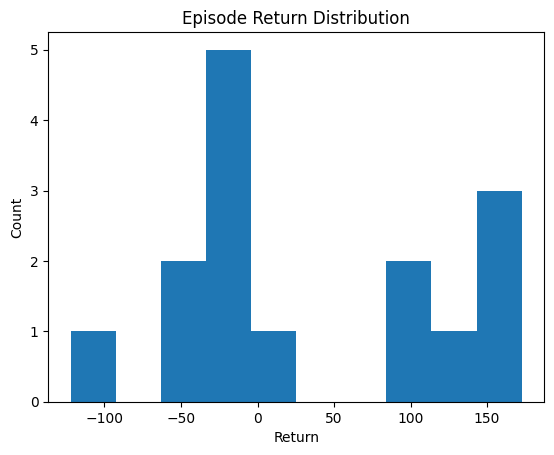

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open("/root/BJ/ERM-IRL/DDC-DPT/datasets/trajs_LL_num_trajs15_train.pkl", "rb") as f:
    d = pickle.load(f)  # list임!

episode_returns = []

for ep in d:  # 각 episode dict
    # reward 합 계산
    G = np.sum(ep["rewards"])
    episode_returns.append(G)

episode_returns = np.array(episode_returns)

# 통계
print("Num episodes:", len(episode_returns))
print("Mean return:", episode_returns.mean())
print("Std return:", episode_returns.std())
print("Min/Max:", episode_returns.min(), episode_returns.max())

# 분포 시각화
plt.hist(episode_returns)
plt.title("Episode Return Distribution")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

Num episodes: 20
Mean return: 41.56032887854472
Std return: 80.24143434041909
Min/Max: -69.55449335713519 167.5495624868069


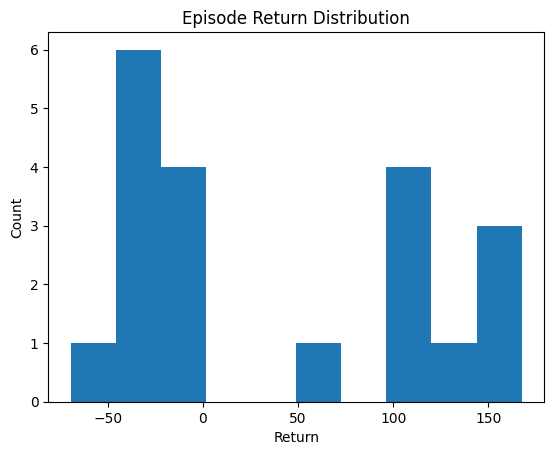

In [10]:
with open("/root/BJ/ERM-IRL/DDC-DPT/datasets/trajs_LL_num_trajs15_test.pkl", "rb") as f:
    d = pickle.load(f)  # list임!

episode_returns = []

for ep in d:  # 각 episode dict
    # reward 합 계산
    G = np.sum(ep["rewards"])
    episode_returns.append(G)

episode_returns = np.array(episode_returns)

# 통계
print("Num episodes:", len(episode_returns))
print("Mean return:", episode_returns.mean())
print("Std return:", episode_returns.std())
print("Min/Max:", episode_returns.min(), episode_returns.max())

# 분포 시각화
plt.hist(episode_returns)
plt.title("Episode Return Distribution")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

In [ ]:
import gym
import torch
import numpy as np

# 환경
env = gym.make("LunarLander-v2")
obs_dim = 8
act_dim = 4

class Actor(torch.nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self._layers = torch.nn.ModuleList([
            torch.nn.Linear(obs_dim, 128),
            torch.nn.Linear(128, 128),
        ])
        self._output_layers = torch.nn.ModuleList([
            torch.nn.Linear(128, 128),
            torch.nn.Linear(128, act_dim),
        ])

    def forward(self, x):
        x = self._layers[0](x)
        x = torch.relu(x)
        x = self._layers[1](x)
        x = torch.relu(x)
        x = self._output_layers[0](x)
        x = torch.relu(x)
        x = self._output_layers[1](x)
        return x
    
# Actor + load
actor = Actor(obs_dim, act_dim)
state_dict = torch.load("/root/BJ/ERM-IRL/DDC-DPT/models/LL_num_trajs15_lr0.0005_batch256_decay0.001_clip1_20260107.log_rep0_epoch20000.pt", map_location="cpu")
actor.load_state_dict(state_dict, strict=False)
actor.eval()

# Rollout 평가
i = 100
num_episodes = 100
returns = [] 
  
for _ in range(num_episodes):
    s = env.reset()
    done = False
    G = 0
    while not done:
        obs_t = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logits = actor(obs_t)
            a = torch.argmax(logits, dim=-1).item()
        s, r, terminated, truncated = env.step(a)
        G += r
        done = terminated or truncated
    returns.append(G)

returns = np.array(returns)

print("Mean Return:", returns.mean())
print("Std:", returns.std())
print("Min/Max:", returns.min(), returns.max())
print("Top 5:", np.sort(returns)[-5:])

/tmp/ipykernel_3780130/1311030632.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/root/BJ/ERM-IRL/DDC-DPT/models/LL_num_trajs15_lr0.0005_batch

Mean Return: -424.72340585745434
Std: 118.56827555404632
Min/Max: -683.1662588215348 -182.18724551837855
Top 5: [-228.65380533 -217.38195153 -213.96049332 -211.71228549 -182.18724552]


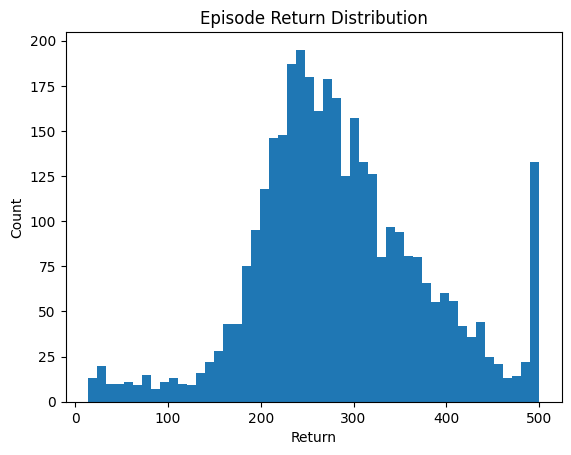

0th percentile: 14.00
1th percentile: 36.01
5th percentile: 150.05
25th percentile: 228.00
50th percentile: 275.00
75th percentile: 341.00
95th percentile: 464.95
99th percentile: 500.00
100th percentile: 500.00


In [5]:
import numpy as np
import matplotlib.pyplot as plt

d = np.load("/root/BJ/ERM-IRL/DDC-DPT/gym/datasets/D_CartPole_medium_mixed.npz")
rewards = d["episode_returns"]

# Histogram
plt.hist(rewards, bins=50)
plt.title("Episode Return Distribution")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

# Percentiles (outlier detection)
for p in [0, 1, 5, 25, 50, 75, 95, 99, 100]:
    print(f"{p}th percentile: {np.percentile(rewards, p):.2f}")

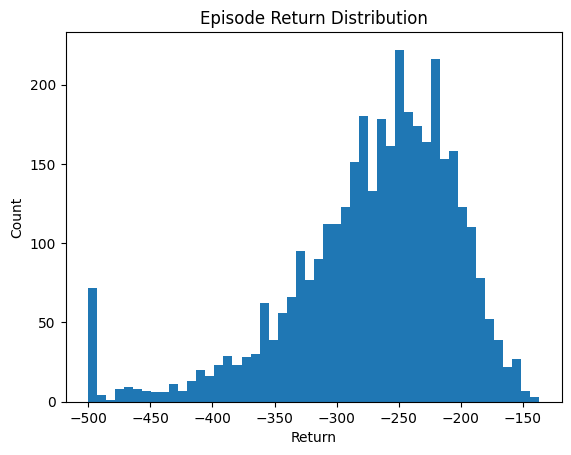

0th percentile: -500.00
1th percentile: -500.00
5th percentile: -400.00
25th percentile: -303.00
50th percentile: -258.00
75th percentile: -222.00
95th percentile: -184.00
99th percentile: -158.86
100th percentile: -137.00


In [4]:
d = np.load("/root/BJ/ERM-IRL/DDC-DPT/gym/datasets/D_Acrobot_medium_mixed.npz")
rewards = d["episode_returns"]

# Histogram
plt.hist(rewards, bins=50)
plt.title("Episode Return Distribution")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

# Percentiles (outlier detection)
for p in [0, 1, 5, 25, 50, 75, 95, 99, 100]:
    print(f"{p}th percentile: {np.percentile(rewards, p):.2f}")

In [6]:
d = np.load("/root/BJ/ERM-IRL/DDC-DPT/gym/datasets/D_CartPole_medium_mixed.npz")

print(d.files)

rewards = d["episode_returns"]
mean_reward = rewards.mean()
std_reward = rewards.std()

print(f"Reward mean: {mean_reward:.2f}")
print(f"Reward std : {std_reward:.2f}")

['obs', 'act', 'rew', 'obs2', 'done', 'episode_returns']
Reward mean: 285.49
Reward std : 93.27
